# Facial Expression Classification with CNN in PyTorch

In this notebook, we will build a **Convolutional Neural Network (CNN)** in PyTorch to classify facial expressions (moods) into the following categories:
- **angry**
- **disgust**
- **fear**
- **happy**
- **neutral**
- **sad**
- **surprise**

This notebook provides:
1. **Detailed explanations** of the concepts and code.
2. A simple and effective CNN architecture.
3. Training and evaluation steps with visualization.

### Dataset Structure
Ensure your dataset is structured as follows:
```
Facial Expression/
    ├── train/
    │       ├── angry/
    │       ├── disgust/
    │       ├── fear/
    │       ├── happy/
    │       ├── neutral/
    │       ├── sad/
    │       └── surprise/
    └── test/
            ├── angry/
            ├── disgust/
            ├── fear/
            ├── happy/
            ├── neutral/
            ├── sad/
            └── surprise/
```

Let's get started!

## 1. Setup

We will start by importing all the required libraries.

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os

print("PyTorch version:", torch.__version__)

PyTorch version: 2.0.1


## 2. Data Loading and Preprocessing

We will load the images using PyTorch's `torchvision.datasets.ImageFolder` and apply transformations (such as resizing, normalization, and data augmentation).

### 2.1 Dataset Paths
Specify the paths to your training and test datasets.

In [13]:
base_dir = 'data/Facial Expression'  # Change this to your dataset folder

train_dir = os.path.join(base_dir, 'train', 'train')
test_dir = os.path.join(base_dir, 'test', 'test')

batch_size = 32
img_size = 48  # Resize all images to 48x48
num_workers = 2  # Number of workers for DataLoader

### 2.2 Data Transformations

We apply:
- **Resize**: Resize all images to 48x48 pixels.
- **Normalization**: Normalize pixel values to have mean 0 and standard deviation 1.
- **Data Augmentation**: Random horizontal flips and rotations to improve generalization.

In [14]:
train_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

test_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

class_names = train_dataset.classes
print("Classes:", class_names)

Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


### 2.3 Visualizing a Batch of Training Images
Let's visualize some training images to ensure our data loading works correctly.

In [15]:
!pip install torchvision

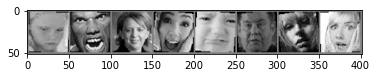

Labels: ['sad', 'angry', 'happy', 'surprise', 'sad', 'fear', 'neutral', 'fear']


In [16]:
def imshow(img, title=None):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.show()

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[:8]))
print("Labels:", [class_names[label] for label in labels[:8]])

## 3. Building the CNN Model

We'll define a simple CNN architecture with:
- **Convolutional layers** to extract spatial features.
- **ReLU activation** to introduce non-linearity.
- **MaxPooling layers** to downsample the feature maps.
- **Fully connected layers** for classification.

### Model Architecture
1. Conv2D -> ReLU -> MaxPool
2. Conv2D -> ReLU -> MaxPool
3. Flatten -> Dense -> ReLU -> Dropout -> Output layer (Softmax)

In [17]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 12 * 12)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = CNN(num_classes=len(class_names)).to(device)
print(model)

Using device: cpu
CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=7, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)


## 4. Training the Model

We'll train the model using:
- **CrossEntropyLoss** as the loss function.
- **Adam optimizer** with a learning rate of 0.001.


In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 200

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

Epoch 1/200, Loss: 1.2567
Epoch 2/200, Loss: 1.2477
Epoch 3/200, Loss: 1.2383
Epoch 4/200, Loss: 1.2238
Epoch 5/200, Loss: 1.2197
Epoch 6/200, Loss: 1.2099
Epoch 7/200, Loss: 1.1991
Epoch 8/200, Loss: 1.1978
Epoch 9/200, Loss: 1.1953
Epoch 10/200, Loss: 1.1846
Epoch 11/200, Loss: 1.1788
Epoch 12/200, Loss: 1.1705
Epoch 13/200, Loss: 1.1645
Epoch 14/200, Loss: 1.1583
Epoch 15/200, Loss: 1.1551
Epoch 16/200, Loss: 1.1474
Epoch 17/200, Loss: 1.1488
Epoch 18/200, Loss: 1.1395
Epoch 19/200, Loss: 1.1386
Epoch 20/200, Loss: 1.1334
Epoch 21/200, Loss: 1.1313
Epoch 22/200, Loss: 1.1263
Epoch 23/200, Loss: 1.1153
Epoch 24/200, Loss: 1.1154
Epoch 25/200, Loss: 1.1089
Epoch 26/200, Loss: 1.1144
Epoch 27/200, Loss: 1.1060
Epoch 28/200, Loss: 1.1009
Epoch 29/200, Loss: 1.0984
Epoch 30/200, Loss: 1.0965
Epoch 31/200, Loss: 1.0941
Epoch 32/200, Loss: 1.0839
Epoch 33/200, Loss: 1.0965
Epoch 34/200, Loss: 1.0933
Epoch 35/200, Loss: 1.0857
Epoch 36/200, Loss: 1.0770
Epoch 37/200, Loss: 1.0795
Epoch 38/2

## 5. Evaluating the Model
Finally, we'll evaluate the model on the test set and calculate the accuracy.

In [23]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 57.84%
